In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
csv_file = "btc_1-min_data.csv"

In [8]:
df = pd.read_csv(csv_file)
df.columns

Index(['Unnamed: 0', 'Open Time', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Quote Asset Volume', 'Number of Trades', 'Taker Buy Base Asset Volume',
       'Taker Buy Quote Asset Volume'],
      dtype='object')

In [ ]:
df = df[['Open Time', 'Close']]
df = df.rename(columns={"Open Time": "date"})
df

,date,Open
0,2017-09-01 00:00:00,4724.89
1,2017-09-01 00:01:00,4689.89
2,2017-09-01 00:02:00,4689.91
3,2017-09-01 00:03:00,4689.91
4,2017-09-01 00:04:00,4689.91
...,...,...
3682084,2024-09-06 23:56:00,53926.01
3682085,2024-09-06 23:57:00,53934.00
3682086,2024-09-06 23:58:00,53952.00
3682087,2024-09-06 23:59:00,53960.26


In [13]:
df['date'] = pd.to_datetime(df['date'])

In [14]:
# Filter out all rows that happened before January 1, 2017.
df = df[df['date'] >= pd.Timestamp('2017-01-01')]
df.sort_values(by='date', inplace=True)
df

,date,Open
0,2017-09-01 00:00:00,4724.89
1,2017-09-01 00:01:00,4689.89
2,2017-09-01 00:02:00,4689.91
3,2017-09-01 00:03:00,4689.91
4,2017-09-01 00:04:00,4689.91
...,...,...
3682084,2024-09-06 23:56:00,53926.01
3682085,2024-09-06 23:57:00,53934.00
3682086,2024-09-06 23:58:00,53952.00
3682087,2024-09-06 23:59:00,53960.26


In [16]:
df['pct_gain'] = df['Open'].pct_change() * 100
df['pct_gain'] = df['pct_gain'].fillna(0)
df

,date,Open,pct_gain
0,2017-09-01 00:00:00,4724.89,0.000000
1,2017-09-01 00:01:00,4689.89,-0.740758
2,2017-09-01 00:02:00,4689.91,0.000426
3,2017-09-01 00:03:00,4689.91,0.000000
4,2017-09-01 00:04:00,4689.91,0.000000
...,...,...,...
3682084,2024-09-06 23:56:00,53926.01,0.006083
3682085,2024-09-06 23:57:00,53934.00,0.014817
3682086,2024-09-06 23:58:00,53952.00,0.033374
3682087,2024-09-06 23:59:00,53960.26,0.015310


In [17]:
df['date_6h'] = df['date'].dt.floor('6H')  # Round down to the nearest 6-hour mark

qs_6h = df.groupby(df['date_6h'])['pct_gain'] \
          .quantile([0.25, 0.75]) \
          .unstack(level=1) \
          .rename(columns={0.25: 'Q1', 0.75: 'Q3'})


# add the IQR column
qs_6h ['IQR'] = qs_6h ['Q3'] - qs_6h ['Q1']

daily_qs = qs_6h [['IQR']]
daily_qs

C:\Users\pryty\AppData\Local\Temp\ipykernel_13776\1576029879.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['date_6h'] = df['date'].dt.floor('6H')  # Round down to the nearest 6-hour mark


,IQR
date_6h,
2017-09-01 00:00:00,0.000000
2017-09-01 06:00:00,0.010168
2017-09-01 12:00:00,0.000000
2017-09-01 18:00:00,0.000052
2017-09-02 00:00:00,0.081031
...,...
2024-09-06 00:00:00,0.069096
2024-09-06 06:00:00,0.069333
2024-09-06 12:00:00,0.163907


In [19]:
daily_avg_open = df.groupby(df['date_6h'])['Open'].mean()
daily_avg_open_df = daily_avg_open.to_frame(name='avg_open')
daily_avg_open_df

,avg_open
date_6h,
2017-09-01 00:00:00,4714.222528
2017-09-01 06:00:00,4725.060361
2017-09-01 12:00:00,4772.975472
2017-09-01 18:00:00,4801.135944
2017-09-02 00:00:00,4809.917111
...,...
2024-09-06 00:00:00,56513.482806
2024-09-06 06:00:00,55996.440528
2024-09-06 12:00:00,55068.910028


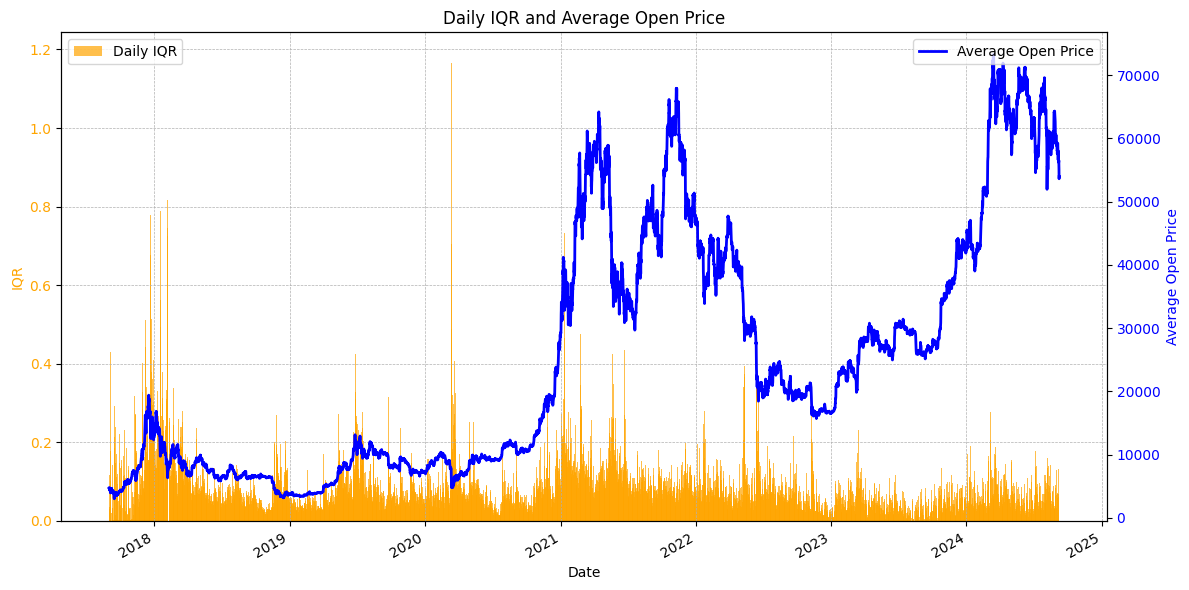

In [20]:
import matplotlib.pyplot as plt

# Ensure the indices of both DataFrames are aligned
daily_qs.index = pd.to_datetime(daily_qs.index)  # Convert daily_qs index to datetime if not already
daily_avg_open_df.index = pd.to_datetime(daily_avg_open_df.index)  # Ensure daily_avg_open_df index is datetime

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the IQR on the first y-axis
ax1.bar(daily_qs.index, daily_qs['IQR'], color='orange', label='Daily IQR', alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel('IQR', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

# Create a second y-axis for the average open price
ax2 = ax1.twinx()
ax2.plot(daily_avg_open_df.index, daily_avg_open_df['avg_open'], color='blue', label='Average Open Price', linewidth=2)
ax2.set_ylabel('Average Open Price', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Add a title and grid
plt.title('Daily IQR and Average Open Price')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Format the x-axis for better readability
fig.autofmt_xdate()

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

In [23]:
import numpy as np
# Define a custom weighted rolling function
def weighted_rolling_sum(df, window):
    weights = np.array([1 / np.log(2 + i) for i in range(window)])  # Compute weights

    # Apply the weighted rolling function
    def apply_weights(x):
        if len(x) < window:
            # Adjust weights for shorter windows at the start
            w = weights[-len(x):]
            return np.sum(x * w)
        return np.sum(x * weights)

    return df.rolling(window=window, min_periods=1).apply(apply_weights, raw=True)

# Apply the custom weighted rolling function to the DataFrame
window = 16  # Define the rolling window size
result_rolling_df = weighted_rolling_sum(daily_qs, window)

# Display the resulting DataFrame
result_rolling_df

,IQR
date_6h,
2017-09-01 00:00:00,0.000000
2017-09-01 06:00:00,0.003589
2017-09-01 12:00:00,0.003667
2017-09-01 18:00:00,0.003773
2017-09-02 00:00:00,0.032472
...,...
2024-09-06 00:00:00,0.640033
2024-09-06 06:00:00,0.635747
2024-09-06 12:00:00,0.661447


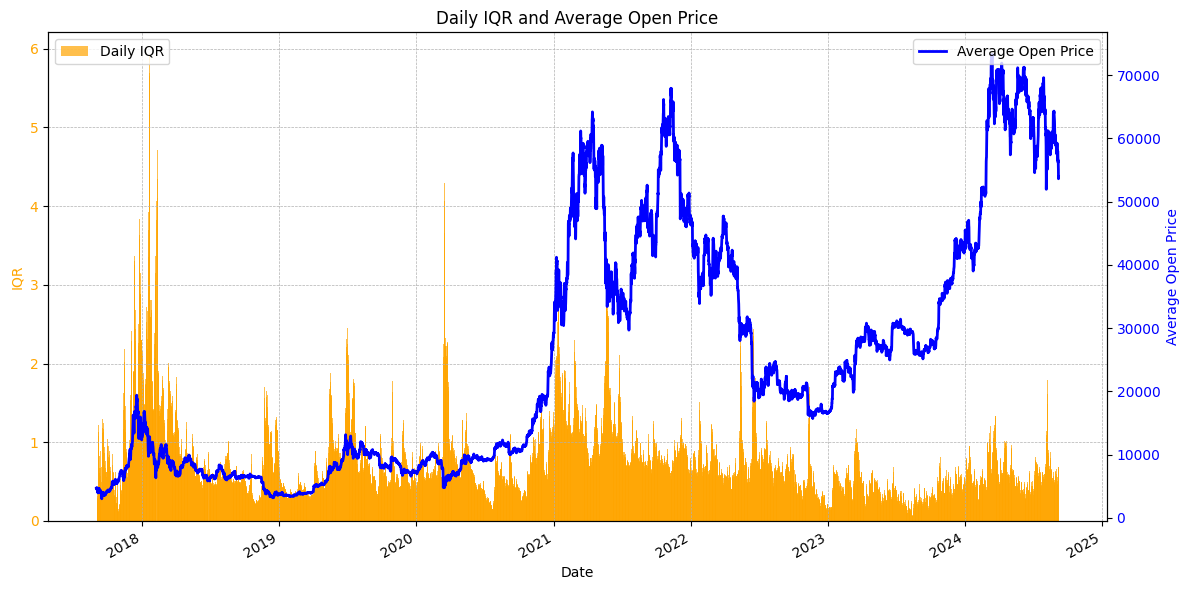

In [24]:
import matplotlib.pyplot as plt

# Ensure the indices of both DataFrames are aligned
result_rolling_df.index = pd.to_datetime(result_rolling_df.index)  # Convert result_rolling_df index to datetime if not already
daily_avg_open_df.index = pd.to_datetime(daily_avg_open_df.index)  # Ensure daily_avg_open_df index is datetime

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the IQR on the first y-axis
ax1.bar(result_rolling_df.index, result_rolling_df['IQR'], color='orange', label='Daily IQR', alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel('IQR', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

# Create a second y-axis for the average open price
ax2 = ax1.twinx()
ax2.plot(daily_avg_open_df.index, daily_avg_open_df['avg_open'], color='blue', label='Average Open Price', linewidth=2)
ax2.set_ylabel('Average Open Price', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Add a title and grid
plt.title('Daily IQR and Average Open Price')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Format the x-axis for better readability
fig.autofmt_xdate()

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

In [25]:
combined_df = result_rolling_df.join(daily_avg_open_df, how='inner')
combined_df

,IQR,avg_open
date_6h,,
2017-09-01 00:00:00,0.000000,4714.222528
2017-09-01 06:00:00,0.003589,4725.060361
2017-09-01 12:00:00,0.003667,4772.975472
2017-09-01 18:00:00,0.003773,4801.135944
2017-09-02 00:00:00,0.032472,4809.917111
...,...,...
2024-09-06 00:00:00,0.640033,56513.482806
2024-09-06 06:00:00,0.635747,55996.440528
2024-09-06 12:00:00,0.661447,55068.910028


In [26]:
combined_df = combined_df.round(6).rename(columns={'IQR': 'IQR', 'avg_open': 'Price'})
combined_df.to_csv('Data Chunks/price_IQR_6h.csv', index=True)

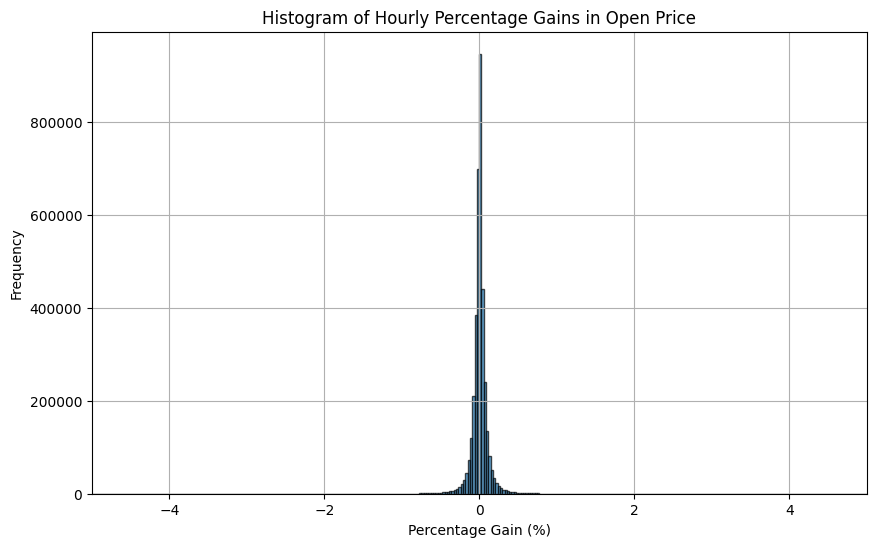

In [27]:
# Plot a histogram of the percentage gains.
plt.figure(figsize=(10, 6))
plt.hist(df['pct_gain'].dropna(), bins=500, edgecolor='black', alpha=0.7)
plt.title('Histogram of Hourly Percentage Gains in Open Price')
plt.xlabel('Percentage Gain (%)')
plt.ylabel('Frequency')
plt.xlim(-5, 5)
# plt.yscale('log')
plt.grid(True)
plt.show()

Fitted degrees of freedom (ν): 1.6930408386329763
Fitted location (μ): 3.609674982731546e-05
Fitted scale (σ): 0.04199907537698853


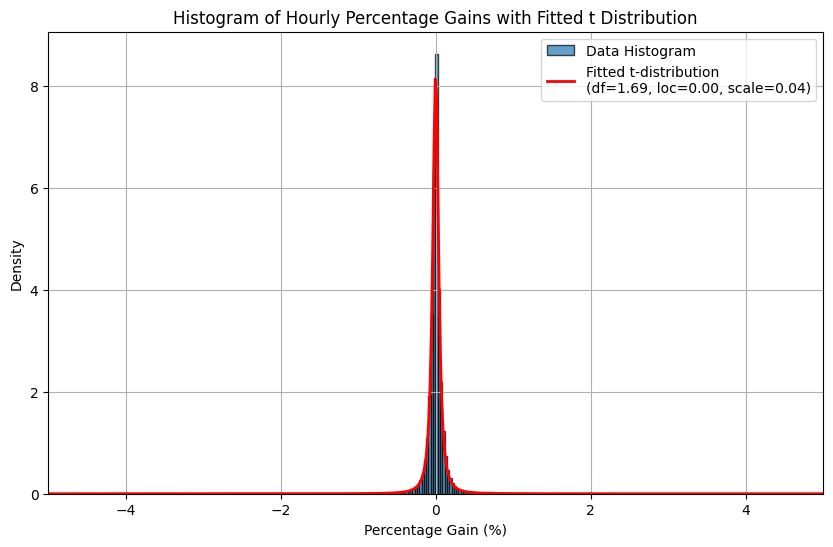

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

# --- Assume df is already loaded and filtered, and 'pct_gain' has been computed ---

# Extract the percentage gains data (dropping NaN values)
data = df['pct_gain'].dropna().values

# Fit the Student's t-distribution to your data.
# SciPy's t.fit returns: degrees of freedom (df), location (loc), and scale (scale)
fitted_df, fitted_loc, fitted_scale = t.fit(data)
print("Fitted degrees of freedom (ν):", fitted_df)
print("Fitted location (μ):", fitted_loc)
print("Fitted scale (σ):", fitted_scale)

# Create a range of x values for plotting the PDF.
# Adjust the range as needed based on the data's spread.
x_min = data.min() - 1
x_max = data.max() + 1
x = np.linspace(x_min, x_max, 1000)

# Calculate the PDF of the fitted t-distribution over x
pdf = t.pdf(x, fitted_df, loc=fitted_loc, scale=fitted_scale)

# Plot the histogram of the data, normalized to form a density.
plt.figure(figsize=(10, 6))
plt.hist(data, bins=500, density=True, edgecolor='black', alpha=0.7, label="Data Histogram")

# Plot the fitted t-distribution PDF
plt.plot(x, pdf, 'r-', lw=2, label=f"Fitted t-distribution\n(df={fitted_df:.2f}, loc={fitted_loc:.2f}, scale={fitted_scale:.2f})")

# Optionally, set the x-axis limits (for example, if you want to zoom in)
plt.xlim(x_min, x_max)

plt.title("Histogram of Hourly Percentage Gains with Fitted t Distribution")
plt.xlabel("Percentage Gain (%)")
plt.ylabel("Density")
plt.legend()
plt.xlim(-5, 5)
plt.grid(True)
plt.show()

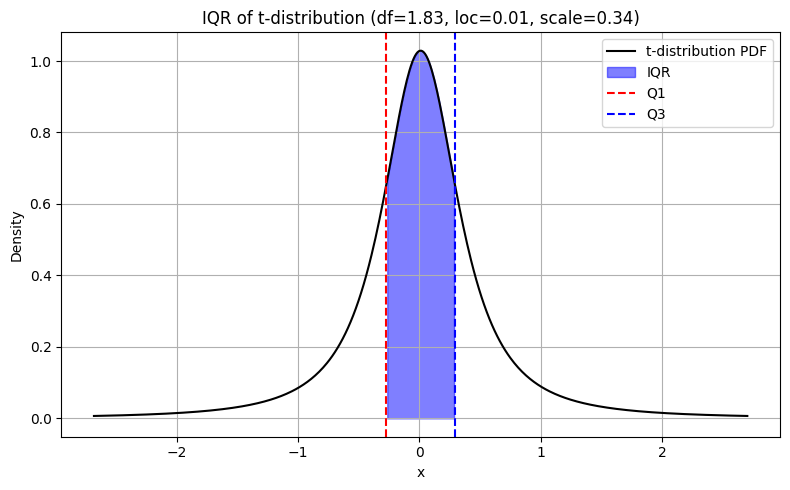

In [8]:
import matplotlib.pyplot as plt
from scipy.stats import t
import numpy as np

# Parameters
df = 1.83
loc = 0.01
scale = 0.34

# Create t-distribution
t_dist = t(df=df, loc=loc, scale=scale)

# Compute quartiles and IQR
q1 = t_dist.ppf(0.25)
q3 = t_dist.ppf(0.75)

# x values for PDF
x = np.linspace(t_dist.ppf(0.01), t_dist.ppf(0.99), 500)
y = t_dist.pdf(x)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, y, label="t-distribution PDF", color="black")
plt.fill_between(x, y, where=(x >= q1) & (x <= q3), color="blue", alpha=0.5, label="IQR")
plt.axvline(q1, color="red", linestyle="--", label="Q1")
plt.axvline(q3, color="blue", linestyle="--", label="Q3")
plt.title("IQR of t-distribution (df=1.83, loc=0.01, scale=0.34)")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
excess_kurtosis = df['pct_gain'].kurtosis()
print("Excess Kurtosis:", excess_kurtosis)

Excess Kurtosis: 28.285724975752192


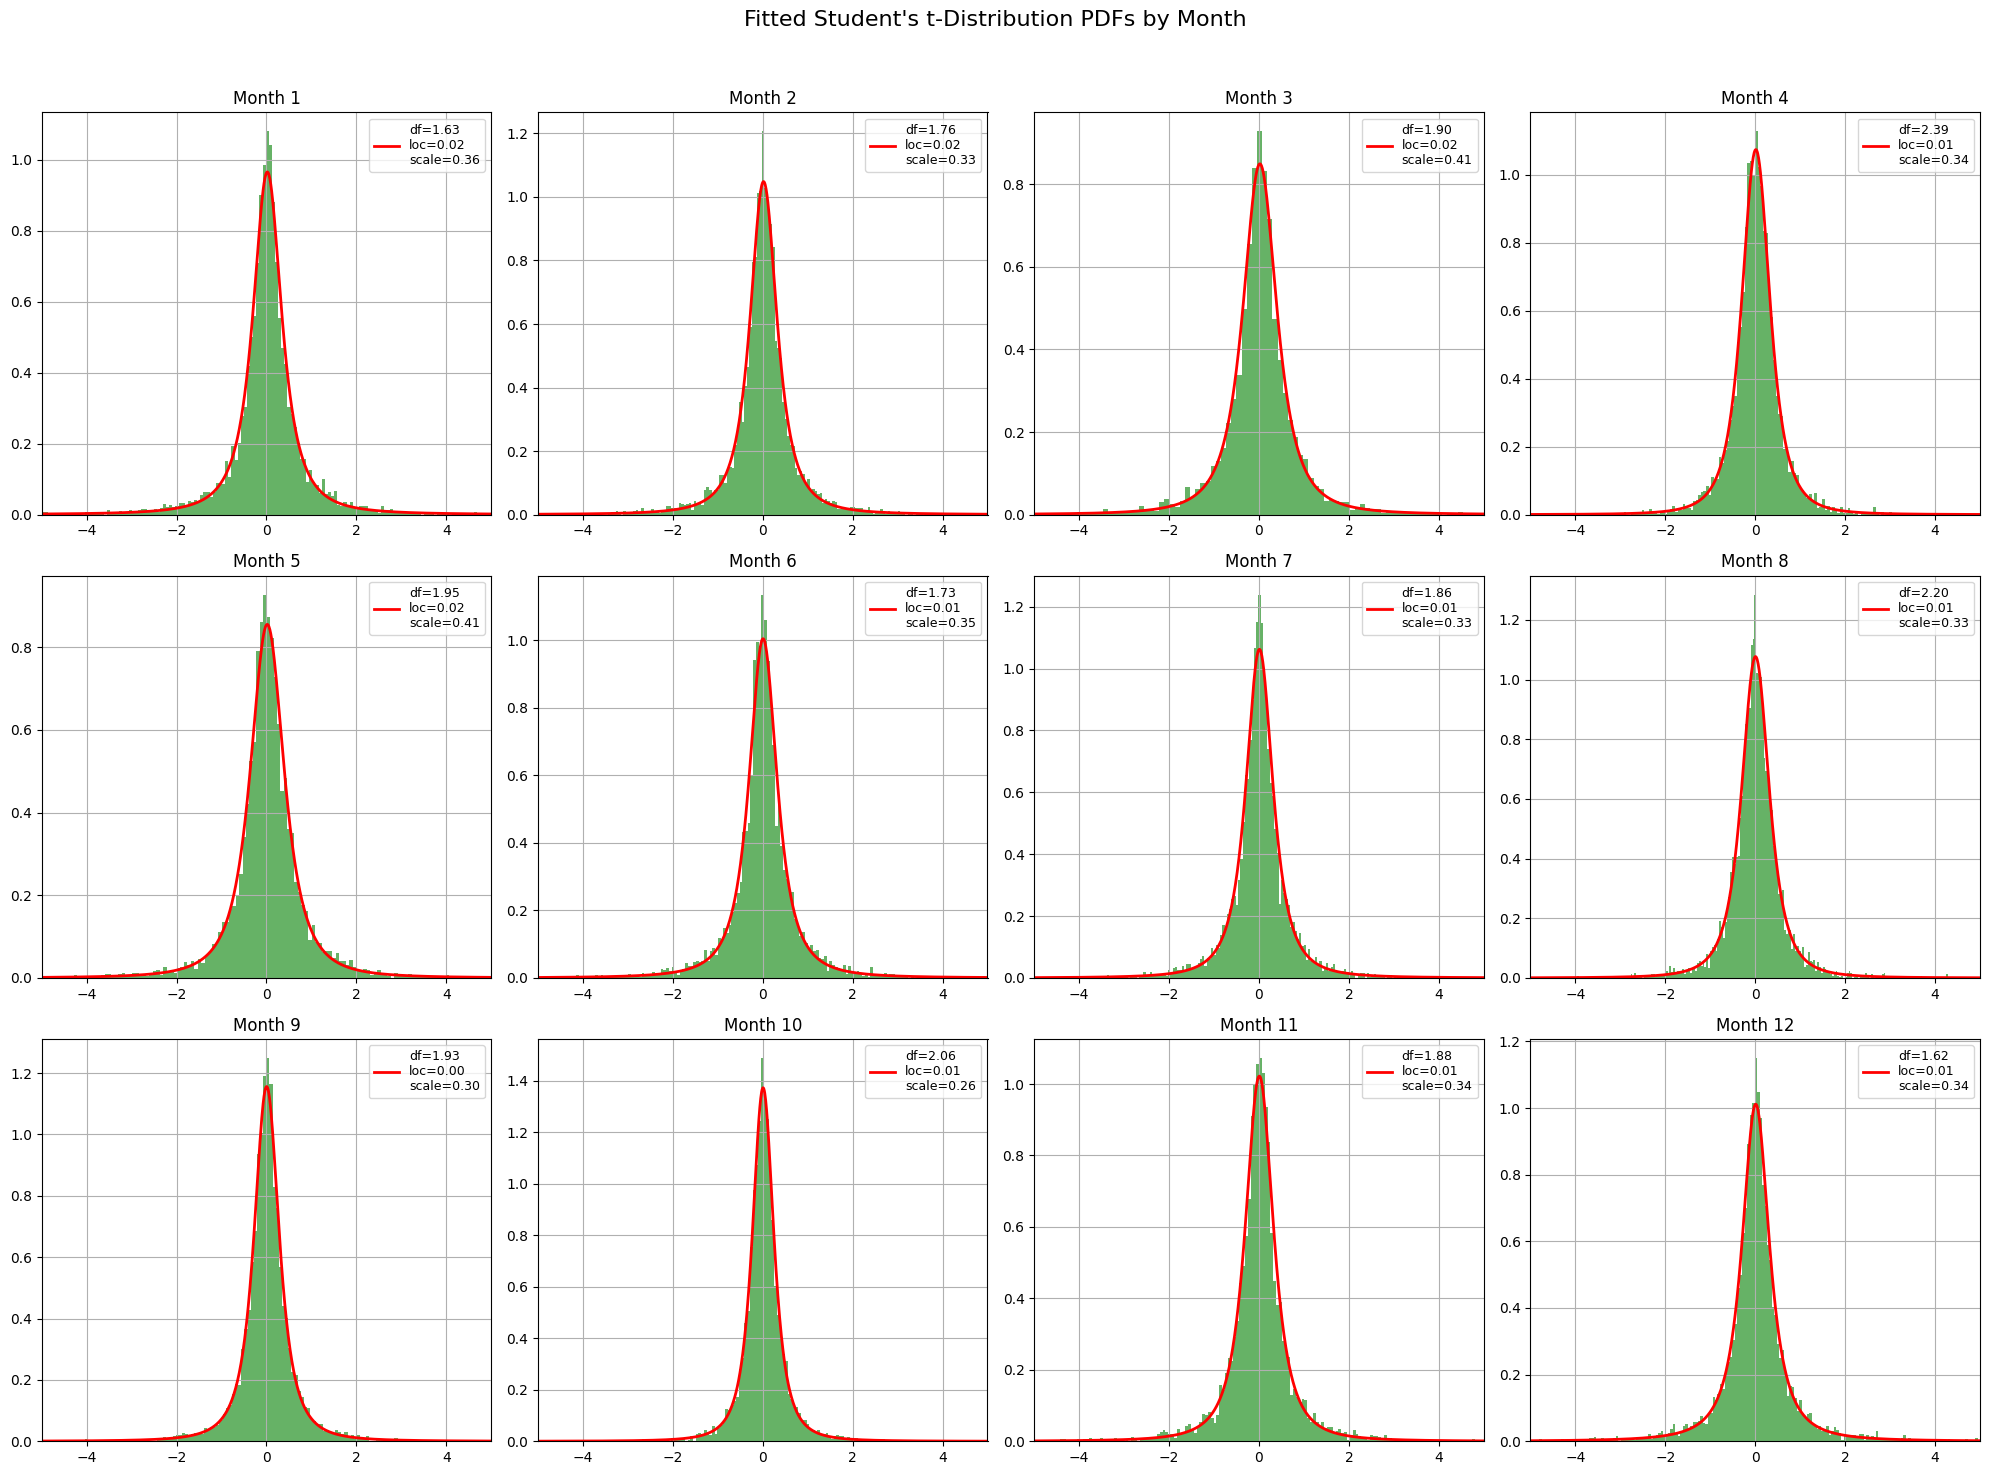

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t
from scipy.optimize import minimize

# Assume df is your DataFrame with a datetime column (named 'datetime')
# and 'pct_gain' column with your hourly percentage gains.
# Ensure the datetime column is already converted to a datetime type:
#   df['datetime'] = pd.to_datetime(df['datetime_str'])

# Define the negative log-likelihood function for the Student's t-distribution.
def neg_log_likelihood(params, data):
    df_t, loc, scale = params
    # Enforce positive constraints for scale and degrees of freedom
    if scale <= 0 or df_t <= 0:
        return np.inf
    return -np.sum(t.logpdf(data, df_t, loc=loc, scale=scale))

# Create subplots with a 3x4 grid to cover all 12 months.
fig, axs = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle("Fitted Student's t-Distribution PDFs by Month", fontsize=16)

# Loop over each month (1 to 12)
for month in range(1, 13):
    # Filter data for the current month and drop NaNs
    month_data = df[df['date'].dt.month == month]['pct_gain'].dropna().values

    # Select the correct subplot axis from the 3x4 grid.
    ax = axs[(month - 1) // 4, (month - 1) % 4]
    
    # If too few data points are available, show a message instead of fitting.
    if len(month_data) < 20:
        ax.text(0.5, 0.5, f"Month {month}\nNot enough data", 
                horizontalalignment='center', fontsize=12, transform=ax.transAxes)
        ax.set_title(f"Month {month}")
        ax.set_xlim(-5, 5)
        continue

    # Set initial guesses: degrees of freedom, location, and scale.
    init_params = [5.0, np.mean(month_data), np.std(month_data)]
    
    # Fit the t-distribution using maximum likelihood estimation.
    res = minimize(neg_log_likelihood, init_params, args=(month_data,),
                   bounds=[(1e-3, None), (None, None), (1e-3, None)])
    
    if not res.success:
        ax.text(0.5, 0.5, f"Month {month}\nFit failed", 
                horizontalalignment='center', fontsize=12, transform=ax.transAxes)
        ax.set_title(f"Month {month}")
        ax.set_xlim(-5, 5)
        continue

    fitted_df, fitted_loc, fitted_scale = res.x

    # Plot the histogram for the month_data with 100 bins and normalized to a density.
    ax.hist(month_data, bins=300, density=True, alpha=0.6, color='g')

    # Create x values for the fitted PDF curve, within the range of -5 to 5.
    x_values = np.linspace(-5, 5, 1000)
    pdf_values = t.pdf(x_values, fitted_df, loc=fitted_loc, scale=fitted_scale)
    
    # Plot the fitted PDF curve.
    ax.plot(x_values, pdf_values, 'r-', linewidth=2, 
            label=f"df={fitted_df:.2f}\nloc={fitted_loc:.2f}\nscale={fitted_scale:.2f}")
    ax.set_title(f"Month {month}")
    ax.set_xlim(-5, 5)
    ax.legend(fontsize=9)
    ax.grid(True)

# Adjust layout to ensure titles and legends fit nicely.
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


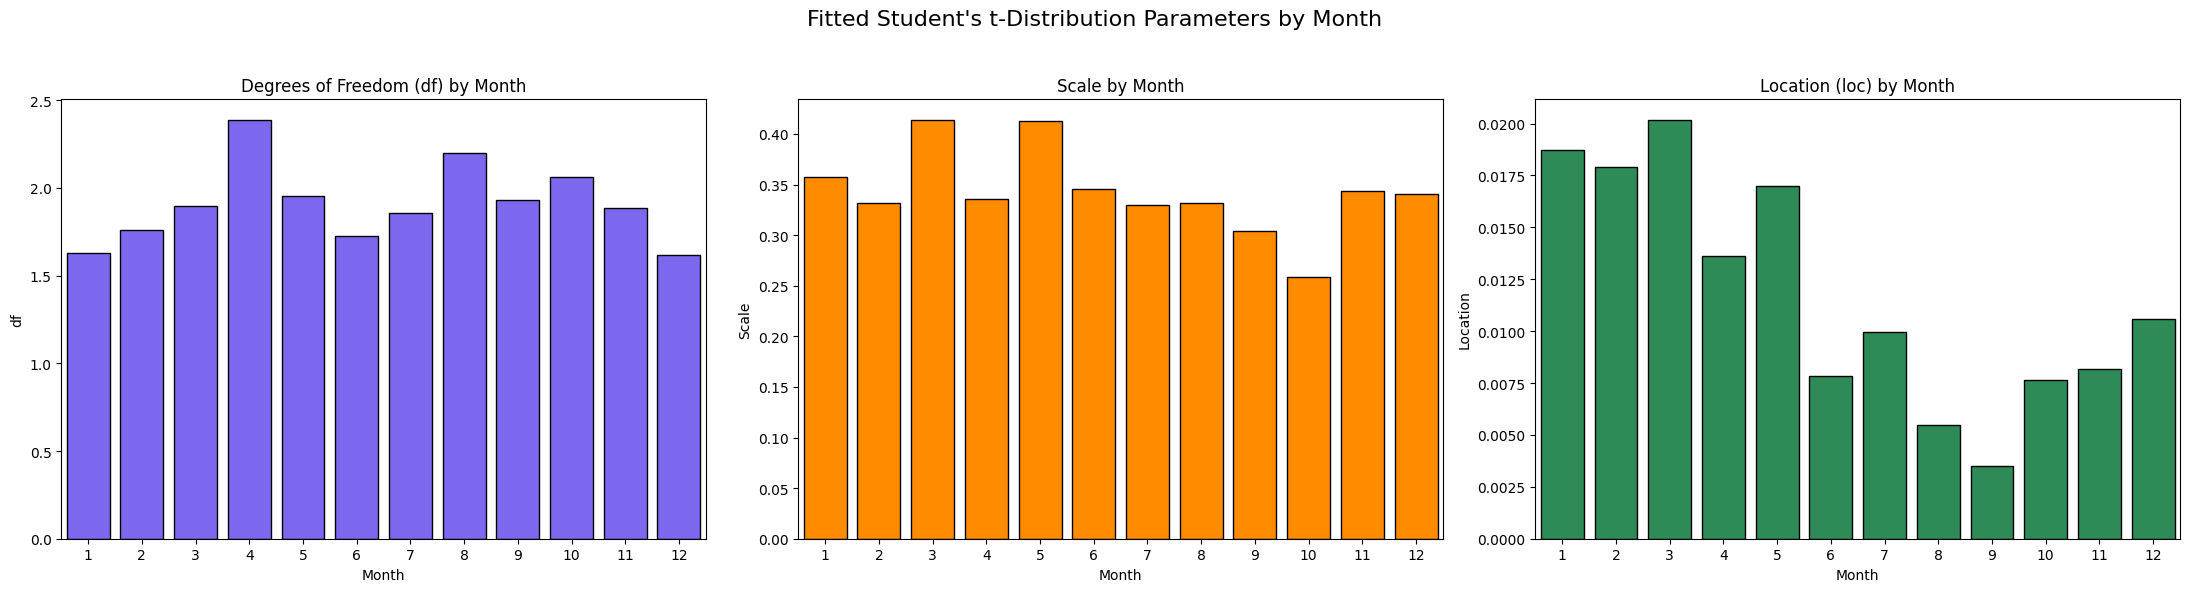

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from scipy.optimize import minimize

# Negative log-likelihood for t-distribution
def neg_log_likelihood(params, data):
    df_t, loc, scale = params
    if scale <= 0 or df_t <= 0:
        return np.inf
    return -np.sum(t.logpdf(data, df_t, loc=loc, scale=scale))

# Storage lists
months = []
fitted_dfs = []
fitted_scales = []
fitted_locs = []

# Loop through each month (1 to 12)
for month in range(1, 13):
    month_data = df[df['date'].dt.month == month]['pct_gain'].dropna().values

    if len(month_data) < 20:
        continue

    init_params = [5.0, np.mean(month_data), np.std(month_data)]
    res = minimize(neg_log_likelihood, init_params, args=(month_data,),
                   bounds=[(1e-3, None), (None, None), (1e-3, None)])

    if res.success:
        fitted_df, fitted_loc, fitted_scale = res.x
        months.append(month)
        fitted_dfs.append(fitted_df)
        fitted_scales.append(fitted_scale)
        fitted_locs.append(fitted_loc)
    else:
        print(f"Fit failed for month {month}")

# Plotting df, scale, and loc
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))

# Degrees of freedom
ax1.bar(months, fitted_dfs, color='mediumslateblue', edgecolor='black')
ax1.set_title("Degrees of Freedom (df) by Month")
ax1.set_xlabel("Month")
ax1.set_ylabel("df")
ax1.set_xticks(range(1, 13))
ax1.set_xlim(0.5, 12.5)

# Scale
ax2.bar(months, fitted_scales, color='darkorange', edgecolor='black')
ax2.set_title("Scale by Month")
ax2.set_xlabel("Month")
ax2.set_ylabel("Scale")
ax2.set_xticks(range(1, 13))
ax2.set_xlim(0.5, 12.5)

# Location
ax3.bar(months, fitted_locs, color='seagreen', edgecolor='black')
ax3.set_title("Location (loc) by Month")
ax3.set_xlabel("Month")
ax3.set_ylabel("Location")
ax3.set_xticks(range(1, 13))
ax3.set_xlim(0.5, 12.5)

plt.suptitle("Fitted Student's t-Distribution Parameters by Month", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


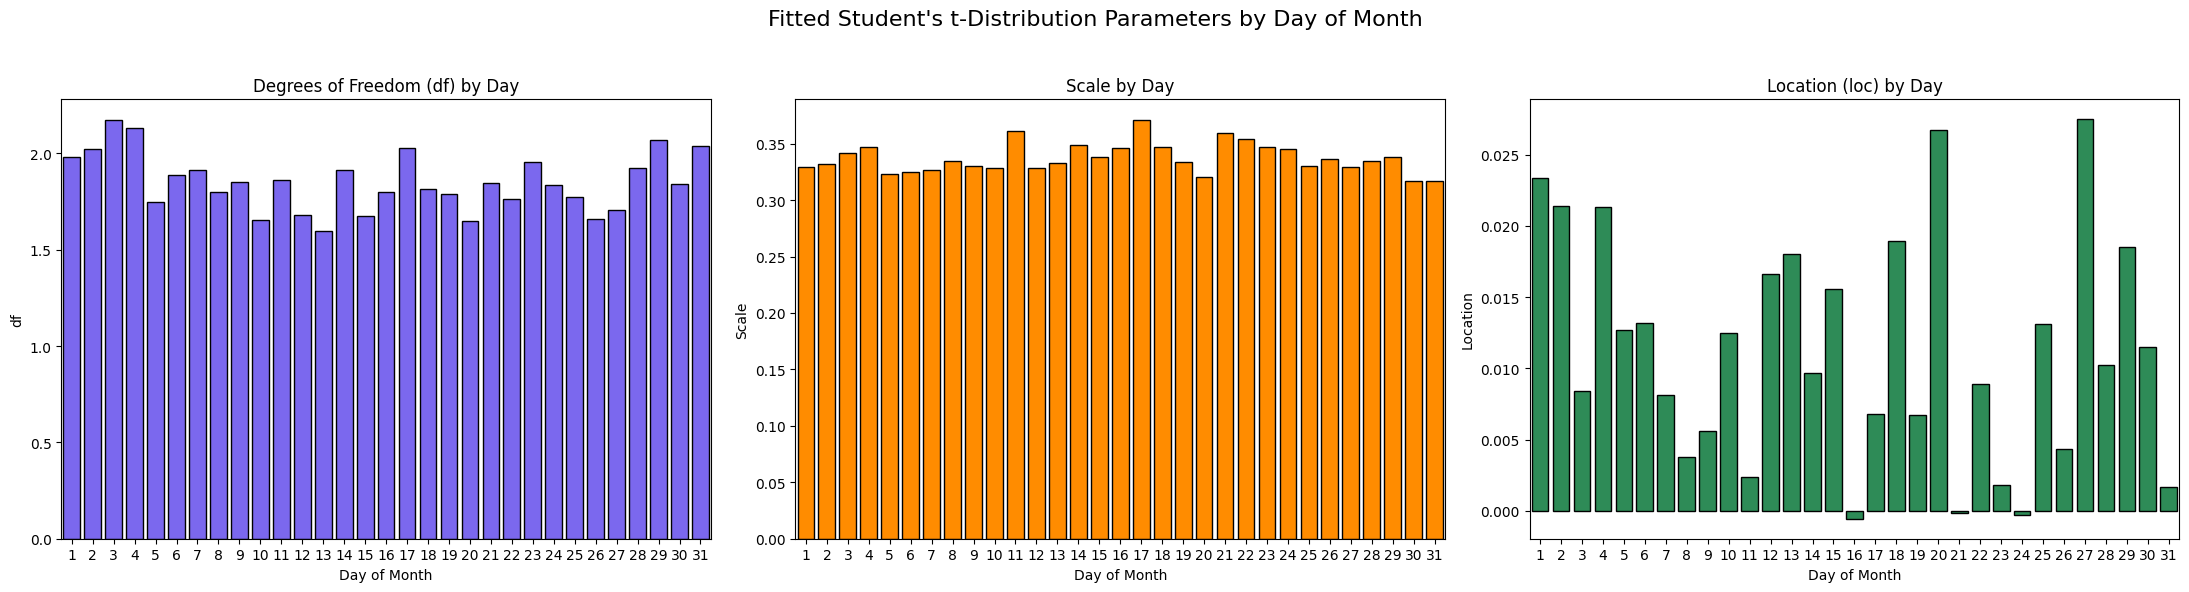

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from scipy.optimize import minimize

# Negative log-likelihood for t-distribution
def neg_log_likelihood(params, data):
    df_t, loc, scale = params
    if scale <= 0 or df_t <= 0:
        return np.inf
    return -np.sum(t.logpdf(data, df_t, loc=loc, scale=scale))

# Lists to collect results
days = []
fitted_dfs = []
fitted_scales = []
fitted_locs = []

# Loop through each day of the month
for day in range(1, 32):
    day_data = df[df['date'].dt.day == day]['pct_gain'].dropna().values

    if len(day_data) < 20:
        continue

    init_params = [5.0, np.mean(day_data), np.std(day_data)]
    res = minimize(neg_log_likelihood, init_params, args=(day_data,),
                   bounds=[(1e-3, None), (None, None), (1e-3, None)])

    if res.success:
        fitted_df, fitted_loc, fitted_scale = res.x
        days.append(day)
        fitted_dfs.append(fitted_df)
        fitted_scales.append(fitted_scale)
        fitted_locs.append(fitted_loc)
    else:
        print(f"Fit failed for day {day}")

# Plotting all three parameters
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))

# Degrees of freedom
ax1.bar(days, fitted_dfs, color='mediumslateblue', edgecolor='black')
ax1.set_title("Degrees of Freedom (df) by Day")
ax1.set_xlabel("Day of Month")
ax1.set_ylabel("df")
ax1.set_xticks(range(1, 32))
ax1.set_xlim(0.5, 31.5)

# Scale
ax2.bar(days, fitted_scales, color='darkorange', edgecolor='black')
ax2.set_title("Scale by Day")
ax2.set_xlabel("Day of Month")
ax2.set_ylabel("Scale")
ax2.set_xticks(range(1, 32))
ax2.set_xlim(0.5, 31.5)

# Location (mean shift)
ax3.bar(days, fitted_locs, color='seagreen', edgecolor='black')
ax3.set_title("Location (loc) by Day")
ax3.set_xlabel("Day of Month")
ax3.set_ylabel("Location")
ax3.set_xticks(range(1, 32))
ax3.set_xlim(0.5, 31.5)

plt.suptitle("Fitted Student's t-Distribution Parameters by Day of Month", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


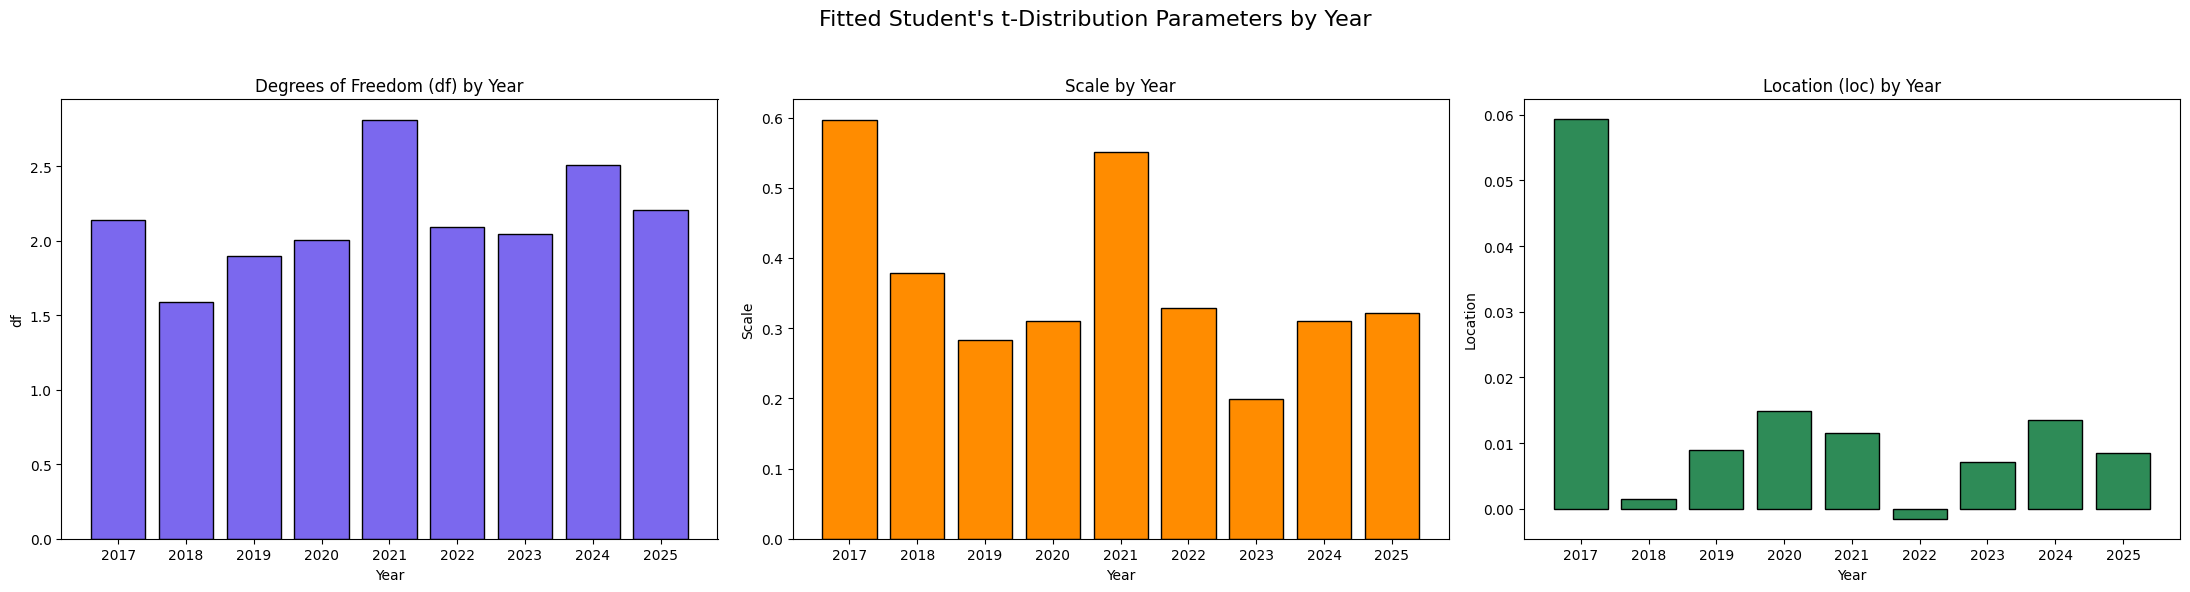

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from scipy.optimize import minimize

# Define negative log-likelihood function
def neg_log_likelihood(params, data):
    df_t, loc, scale = params
    if scale <= 0 or df_t <= 0:
        return np.inf
    return -np.sum(t.logpdf(data, df_t, loc=loc, scale=scale))

# Initialize storage for results
years = []
fitted_dfs = []
fitted_scales = []
fitted_locs = []

# Loop through each year in the data
for year in df['date'].dt.year.sort_values().unique():
    year_data = df[df['date'].dt.year == year]['pct_gain'].dropna().values

    if len(year_data) < 20:
        continue

    init_params = [5.0, np.mean(year_data), np.std(year_data)]
    res = minimize(neg_log_likelihood, init_params, args=(year_data,),
                   bounds=[(1e-3, None), (None, None), (1e-3, None)])

    if res.success:
        fitted_df, fitted_loc, fitted_scale = res.x
        years.append(year)
        fitted_dfs.append(fitted_df)
        fitted_scales.append(fitted_scale)
        fitted_locs.append(fitted_loc)
    else:
        print(f"Fit failed for year {year}")

# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))

# Degrees of freedom
ax1.bar(years, fitted_dfs, color='mediumslateblue', edgecolor='black')
ax1.set_title("Degrees of Freedom (df) by Year")
ax1.set_xlabel("Year")
ax1.set_ylabel("df")
ax1.set_xticks(years)

# Scale
ax2.bar(years, fitted_scales, color='darkorange', edgecolor='black')
ax2.set_title("Scale by Year")
ax2.set_xlabel("Year")
ax2.set_ylabel("Scale")
ax2.set_xticks(years)

# Location
ax3.bar(years, fitted_locs, color='seagreen', edgecolor='black')
ax3.set_title("Location (loc) by Year")
ax3.set_xlabel("Year")
ax3.set_ylabel("Location")
ax3.set_xticks(years)

plt.suptitle("Fitted Student's t-Distribution Parameters by Year", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [57]:
from scipy.stats import t, laplace
import numpy as np

data = df['pct_gain'].dropna().values

# Fit both distributions
t_params = t.fit(data)
laplace_params = laplace.fit(data)

# Calculate log-likelihood
loglik_t = np.sum(t.logpdf(data, *t_params))
loglik_laplace = np.sum(laplace.logpdf(data, *laplace_params))

print("Log-likelihood (t):", loglik_t)
print("Log-likelihood (Laplace):", loglik_laplace)

Log-likelihood (t): -66469.99624373844
Log-likelihood (Laplace): -68822.68839652099


In [61]:
!pip install seaborn

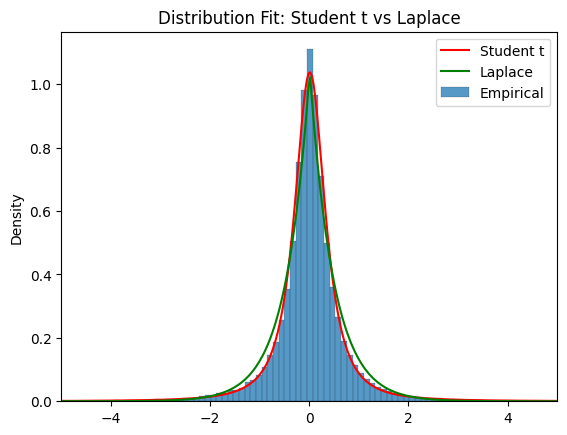

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data, bins=300, kde=False, stat='density', label='Empirical')

x = np.linspace(min(data), max(data), 1000)
plt.plot(x, t.pdf(x, *t_params), label='Student t', color='red')
plt.plot(x, laplace.pdf(x, *laplace_params), label='Laplace', color='green')
plt.legend()
plt.xlim(-5,5)
plt.title('Distribution Fit: Student t vs Laplace')
plt.show()
